# Fundamentals Of Machine Learning - Final Project

## Alphonso Miguel T. Balagtas, 2015-06921

Final Project for CoE 197 under Prof. Atienza

Part 1: Low-dimensionality reduction using PCA
Using STL-10 10k unlabeled dataset, build a PCA with the minimum dimensionality and best reconstruction quality.


Plot 𝑀𝑆𝐸 vs 𝒛−𝑑𝑖𝑚 


	Mean squared error for the entire test set vs 𝒛 code dimensionality
    
    
Try the following dims: {32, 64, 256, 512, 1028, 2046, 4098}

First we import necessary libraries. Many of these are for the simple purpose of loading the dataset

In [1]:
import os
import urllib.request as urllib
import tarfile
import sys
import matplotlib.pyplot as plt
import numpy as np
import keras

## Note:
Some of the cells take very long to run. I've tried to include time estimates in the comments or using the time library to indicate which cells take particularly long to run

Since I had trouble downloading the entire dataset while using Colab (my internet would disconnect and the entire thing would have to restart), I instead downloaded the files from "https://ai.stanford.edu/~acoates/stl10/". Once you download the binary files, simply create a folder called stl10_data in your working directory, then move the binary file into that folder. After that, running the code below should work just fine.

If you're having issues with that, then the first few cells of code from here: "https://github.com/matanby/keras-examples/blob/master/stl10.ipynb" should work with Google Colab or even in a local Jupyter Notebook just fine.

In [2]:
# the dimensions of each image in the STL-10 dataset (96x96x3).
HEIGHT, WIDTH, DEPTH = 96, 96, 3

# number of classes in the STL-10 dataset.
N_CLASSES = 10

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './stl10_data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'
DATA_URL = 'stl10_binary.tar'

# path to the binary train file with image data
TRAIN_DATA_PATH = DATA_DIR + '/stl10_binary/train_X.bin'


# path to the binary test file with image data
TEST_DATA_PATH = DATA_DIR + '/stl10_binary/test_X.bin'

UNLABELLED_DATA_PATH = DATA_DIR + '/stl10_binary/unlabeled_X.bin'

# path to the binary train file with labels
TRAIN_LABELS_PATH = DATA_DIR + '/stl10_binary/train_y.bin'

# path to the binary test file with labels
TEST_LABELS_PATH = DATA_DIR + '/stl10_binary/test_y.bin'

# path to class names file
CLASS_NAMES_PATH = DATA_DIR + '/stl10_binary/class_names.txt'

In [3]:

def read_labels(path_to_labels):
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

''' The first thing you need to do is create a folder called stl10_data in your working directory, then place
the .tar file that you downloaded from __ inside it.'''

def read_all_images(path_to_data):
    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, DEPTH, WIDTH, HEIGHT))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def download_and_extract():
    # if the dataset already exists locally, no need to download it again.
    if all((
        os.path.exists(TRAIN_DATA_PATH),
        #os.path.exists(TRAIN_LABELS_PATH),
        os.path.exists(TEST_DATA_PATH),
        os.path.exists(UNLABELLED_DATA_PATH),
        #os.path.exists(TEST_LABELS_PATH),
    )):
        return

    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
        
    #filename = DATA_URL
    #filepath = os.path.join(dest_directory, filename)
    #filepath = '/stl10_data/stl10_binary.tar.gz'
    filepath = os.path.abspath("stl10_data/stl10_binary.tar.gz")
    #print(filepath)
    #if not os.path.exists(filepath):
        #def _progress(count, block_size, total_size):
            #sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                                                          #float(count * block_size) / float(total_size) * 100.0))
            #sys.stdout.flush()

        #filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        #print('Downloaded', filename)
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)


def load_dataset():
    # download the extract the dataset.
    download_and_extract()

    # load the train and test data and labels.
    x_train = read_all_images(TRAIN_DATA_PATH)
    y_train = read_labels(TRAIN_LABELS_PATH)
    x_test = read_all_images(TEST_DATA_PATH)
    y_test = read_labels(TEST_LABELS_PATH)
    #unlabelled = read_all_images(UNLABELLED_DATA_PATH)

    # convert all images to floats in the range [0, 1]
    x_train = x_train.astype('float32')
    x_train = (x_train ) / 255
    x_test = x_test.astype('float32')
    x_test = (x_test) / 255
    #unlabelled = unlabelled.astype('float32')
    #unlabelled = (unlabelled - 127.5) / 127.5
    # convert the labels to be zero based.
    #y_train -= 1
    #y_test -= 1

    # convert labels to hot-one vectors.
    #y_train = keras.utils.to_categorical(y_train, N_CLASSES)
    #y_test = keras.utils.to_categorical(y_test, N_CLASSES)

    #return (x_train, y_train), (x_test, y_test), unlabelled
    return (x_train), (x_test), y_train, y_test

In [4]:
(x_train), (x_test), y_train, y_test = load_dataset()
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(5000, 96, 96, 3) (8000, 96, 96, 3)
(5000,) (8000,)


In [5]:
np.unique(y_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

Let's check if the values were properly normalized

In [6]:
print(x_train.max())
print(x_train.min())

1.0
0.0


Next cell is to load the unlabelled dataset. I separated this part from the ones above because doing all of them at once was quite heavy for my computer

In [6]:
def load_unlabelled():

    unlabelled = read_all_images(UNLABELLED_DATA_PATH)
    #RAM crashes if not
    #unlabelled = unlabelled.astype('float32')
    #unlabelled = (unlabelled - 127.5) / 127.5

    return unlabelled

In [7]:
unlabelled = load_unlabelled()
print(unlabelled.shape)

(100000, 96, 96, 3)


Our STL-10 dataset consists of 96x96 pixel colored images. The train and test set consist of 5,000 and 8,000 images respectively. The unlabelled set consists of 100,000 images.




First, let's take a look at some of these images.

In [9]:
test_images = unlabelled[0:100]

In [10]:
output_image = test_images
output_image.shape

(100, 96, 96, 3)

Here, we plot out 100 images from the unlabelled dataset.

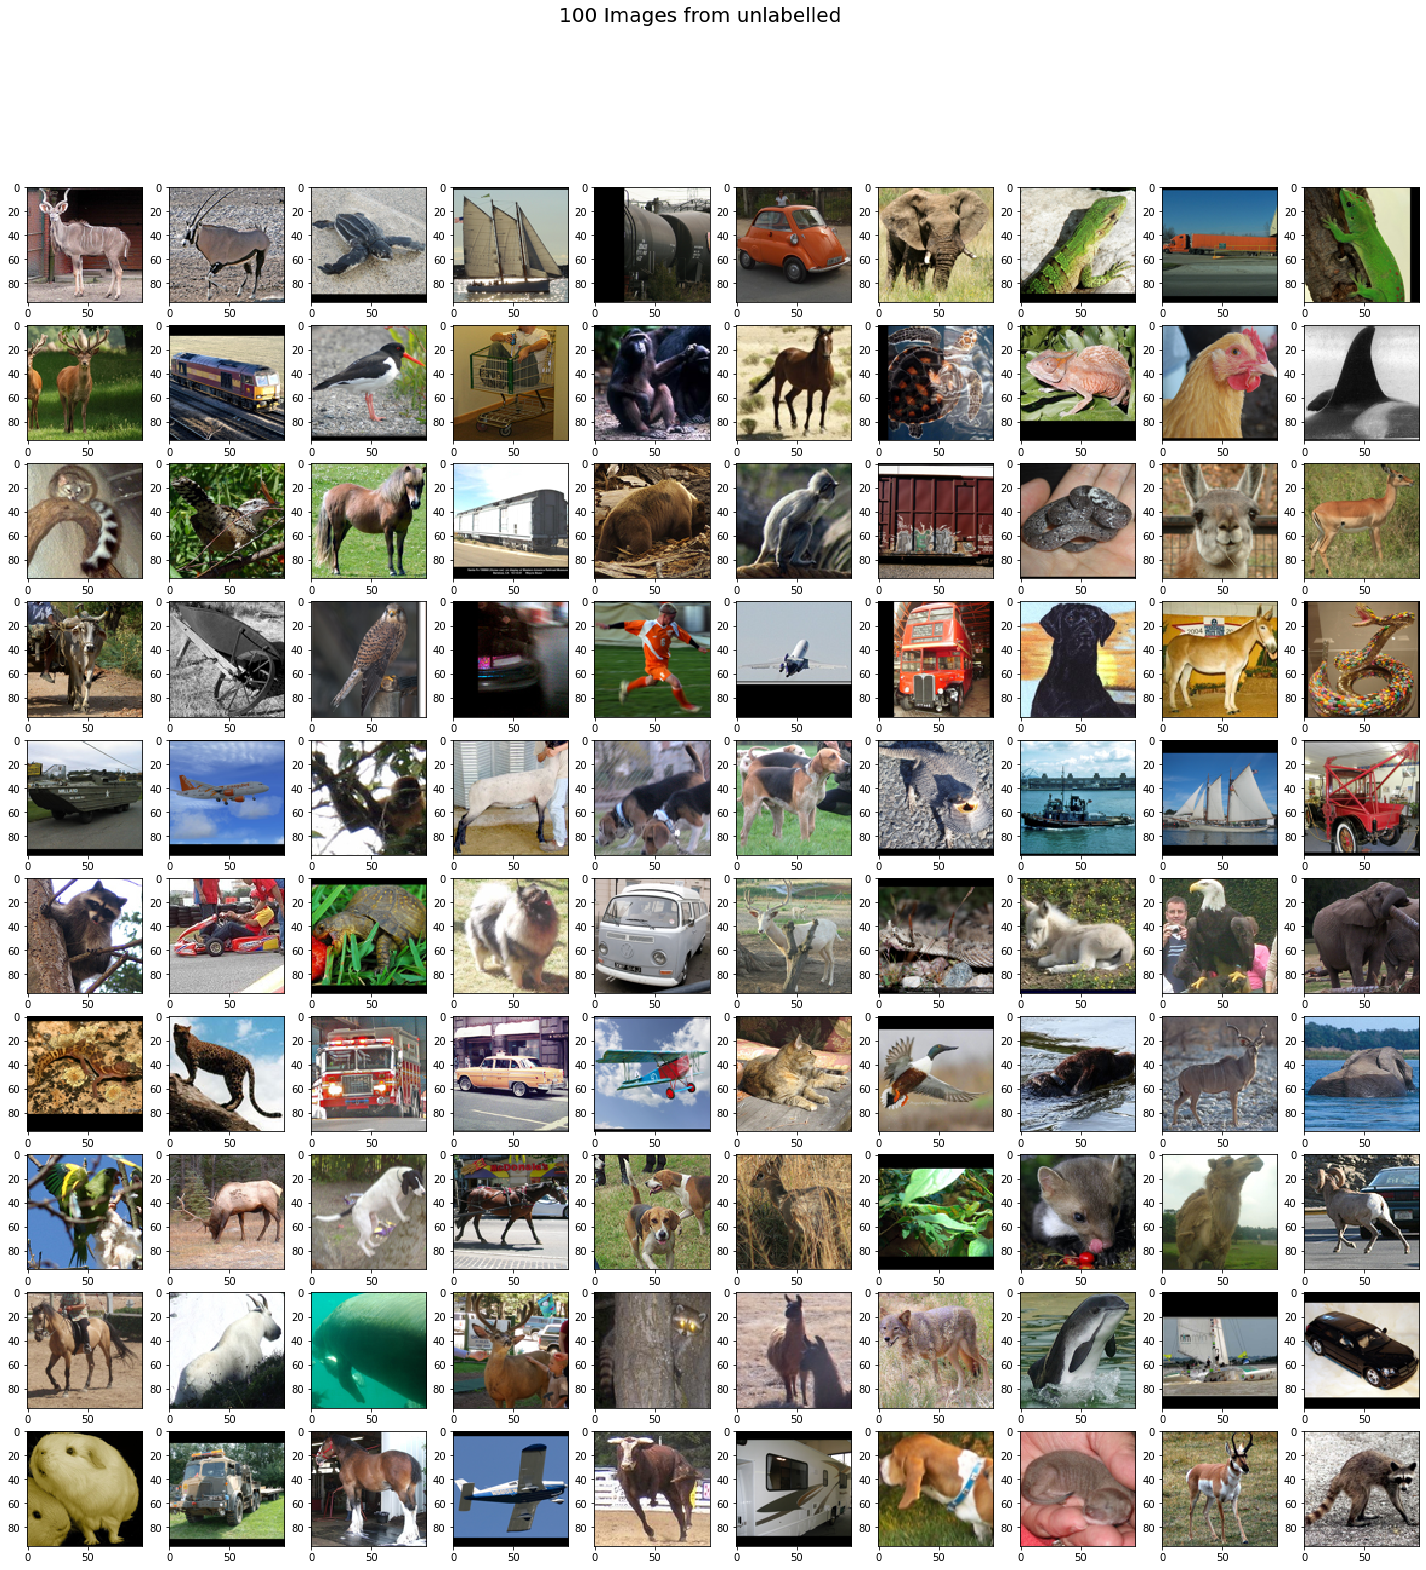

In [11]:
fig = plt.figure(figsize=(25, 25))  # width, height in inches
fig.suptitle("100 Images from unlabelled", fontsize = 20)
for i in range(100):
    sub = fig.add_subplot(10, 10, i + 1)

    sub.imshow(output_image[i,:,:,:], interpolation='nearest')

## PCA Algorithm

PCA refers to Principal Component Analysis. It is normally used to condense large information into its principal components, usually so that performing Machine Learning algorithms on this information becomes more time-efficient while still retaining the most important data. For our purposes, we will use it to condense our images into a smaller version. Afterwards, we will try to reconstruct the images to see how effective our process was. 

In order to demonstrate the algorithm more clearly, I will first perform PCA on only a grayscale version of our dataset. However, the process can and will be applied in 3-channels (RGB) later on.

The image below shows the specific steps in the PCA algorithm

![title](https://www.researchgate.net/profile/Indrajeet_Kumar7/publication/324768723/figure/fig2/AS:754448490037250@1556885945851/Steps-involved-in-PCA.ppm)

In [8]:
# We create the function below to implement the steps listed above

def principal_components(A, n_components = 50):
    # A is a 2D matrix representing grayscale pixel values of an image
    
    # normalizing the matrix by subtracting the mean (along columns)
    A_norm = (A-np.mean(A.T,axis=1)).T
    
    # computing eigenvalues and eigenvectors of covariance matrix
    [e_vals,e_vecs] = np.linalg.eig(np.cov(A_norm))
    
    # sorting the eigenvalues and eigenvectors in descending order
    idx = np.argsort(-e_vals) 
    e_vals = e_vals[idx]
    e_vecs = e_vecs[:,idx]
    
    # taking only the top n_components
    e_vals = e_vals[:n_components]
    e_vecs = e_vecs[:,range(n_components)].real

    # projection of the data in the new space
    proj = np.dot(e_vecs.T,A_norm)

    return e_vecs,proj,e_vals

In [13]:
# Get our one image for demonstration purposes

one_image = unlabelled[0:1]

# Don't forget to normalize
one_image = one_image.astype('float32')
one_image = (one_image ) / 255
one_image = one_image.reshape(96, 96, 3)

In [14]:
one_image.shape

(96, 96, 3)

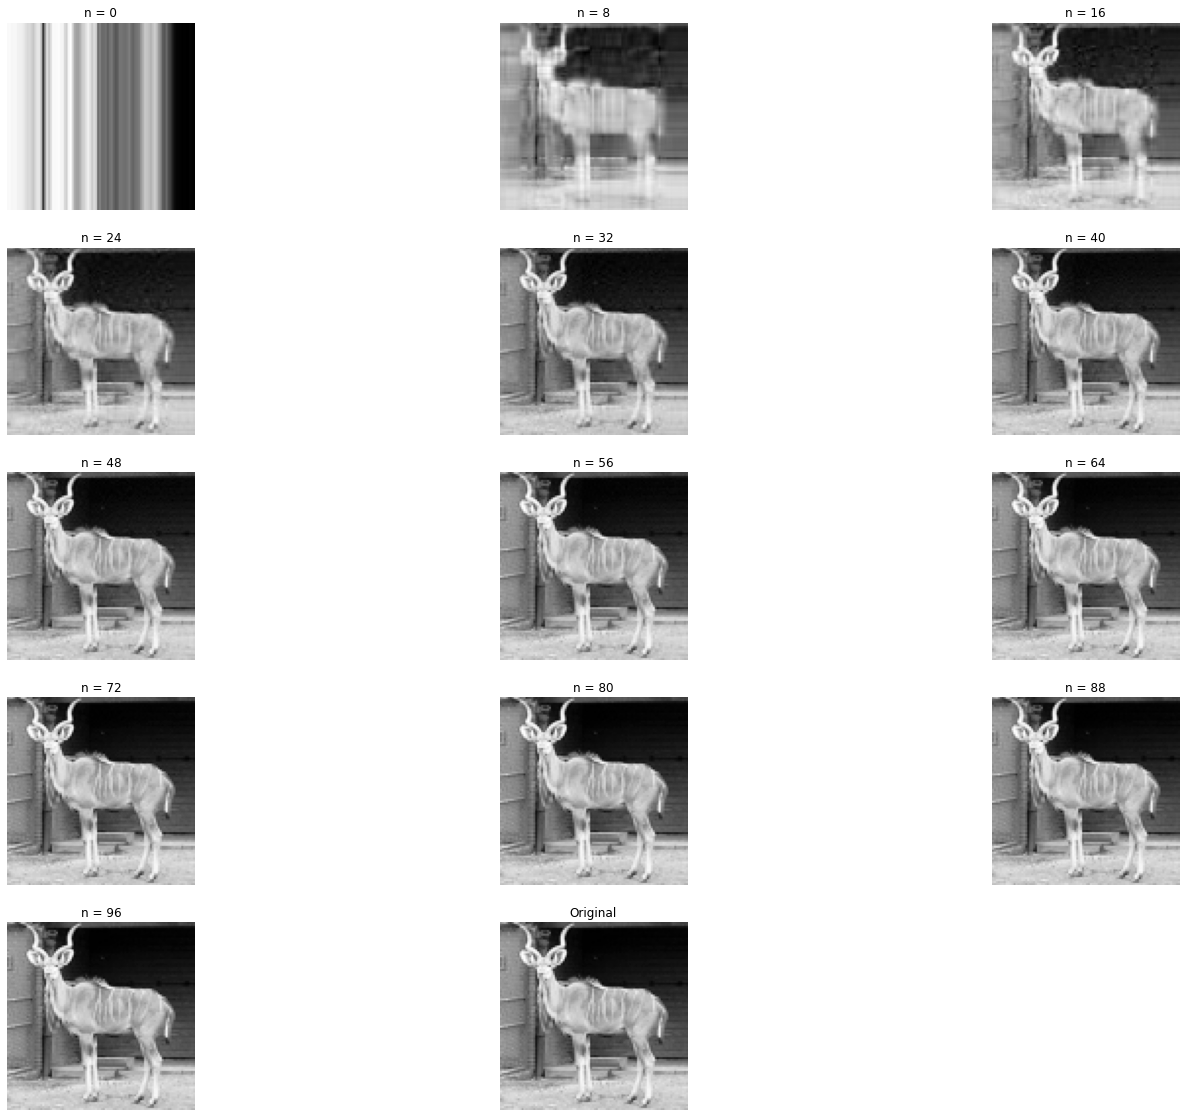

In [15]:
X = one_image
if len(X.shape) > 2:
    X = np.mean(X,2) # 
# number of columns
n_components = np.size(X,axis=1)

dist = []

max_components = 96
step = 8

i = 1
n_columns = 3
n_images = max_components/step/n_columns + 1

fig = plt.figure(figsize=(25, 20))

for n in range(0,max_components+step,step):
    e_vecs,proj,e_vals = principal_components(X, n)
    
    # Reconstructing original image from the projection
    Xr_b = np.dot(e_vecs,proj).T + np.mean(X,axis=0)
    
    # Distance between original and reconstruction
    dist.append(np.linalg.norm(X-Xr_b))
    
    fig.add_subplot(n_images, n_columns, i)
    plt.imshow(Xr_b, cmap='Greys_r')
    plt.axis('off')
    plt.title("n = %d" % n)
    
    i += 1

fig.add_subplot(n_images, n_columns, i)
plt.imshow(X, cmap='Greys_r')
plt.axis('off');
plt.title("Original");

The images above show how they would look with only n principal components. Note that as more principal components are included, the quality improves. 

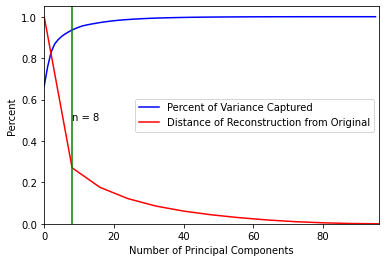

In [16]:
# Percent of original variance accounted for
percent = np.cumsum(e_vals)/sum(e_vals)

# Difference between the original and the rescontruction
dist = dist/max(dist)

plt.plot(range(len(percent)),percent,'b', label="Percent of Variance Captured")
plt.plot(range(0,max_components+step,step),dist,'r', label="Distance of Reconstruction from Original")
plt.axis([0,max_components,0,1.05])
plt.legend(loc="center right")
plt.ylabel("Percent")
plt.xlabel("Number of Principal Components")
plt.axvline(x=8, color = 'green')
plt.text(8,0.5,"n = 8",rotation=0);

The graph above plots the total percent of variance captured versus the number of principal components in the reconstructed image. Notice how around n = 8 is when majority of the variance is already captured by the reconstruction. However, if you look at the image reconstructed at n = 8, it is still very blurry.

Next, we'll try to apply this process to colored images.

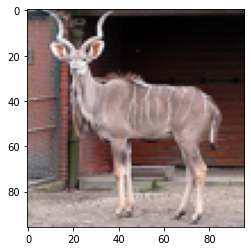

In [17]:
plt.imshow(one_image);

This is what our one colored image looks like for reference

The function below is used to extend our earlier pca function onto 3 separate channels at first, then combine all of them at the end to reconstruct our original image

In [9]:
def pca_3d(red, green, blue, num_components):
    e_vecs_red,proj_red,e_vals_red = principal_components(red, num_components)
    Xr_r = np.dot(e_vecs_red,proj_red).T + np.mean(red,axis=0)
    
    e_vecs_green,proj_green,e_vals_green = principal_components(green, num_components)
    Xr_g = np.dot(e_vecs_green,proj_green).T + np.mean(green,axis=0)
    
    e_vecs_blue,proj_blue,e_vals_blue = principal_components(blue, num_components)
    Xr_b = np.dot(e_vecs_blue,proj_blue).T + np.mean(blue,axis=0)
    
    rgb_uint8 = (np.dstack((Xr_r,Xr_g,Xr_b)) ) 
    rgb_uint8 = np.clip(rgb_uint8, 0, 1)
    
    
    
    #For Plotting
    plt.figure(figsize=(10,5));
    plt.imshow(rgb_uint8);
    plt.title('{} Principal components'.format(num_components));
    

    return rgb_uint8;

In [19]:
# We do this to split the image into 3 channels

unl_r = one_image[:,:,0]
unl_g = one_image[:,:,1]
unl_b = one_image[:,:,2]

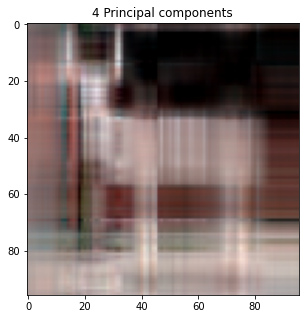

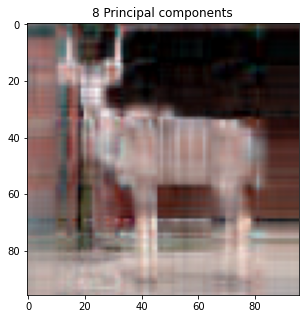

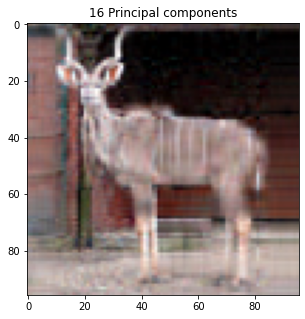

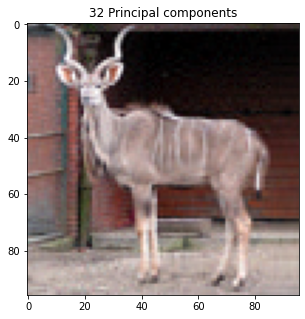

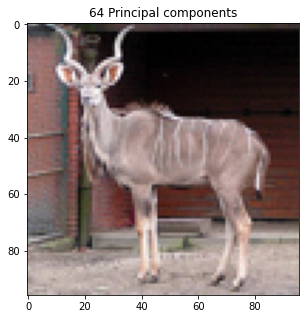

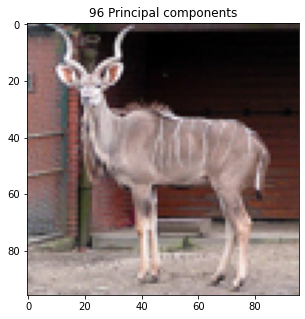

In [20]:
pca_3d(unl_r, unl_g, unl_b, 4);
pca_3d(unl_r, unl_g, unl_b, 8);
pca_3d(unl_r, unl_g, unl_b, 16);
pca_3d(unl_r, unl_g, unl_b, 32);
pca_3d(unl_r, unl_g, unl_b, 64);
pca_3d(unl_r, unl_g, unl_b, 96);

Just as in grayscale, the colored images improve in quality the more principal components are used. At around n=8, the image becomes fairly recognizable already

### Next step: Apply on dataset

Plot 𝑀𝑆𝐸 vs 𝒛−𝑑𝑖𝑚 


	Mean squared error for the entire test set vs 𝒛 code dimensionality
    
    
Try the following dims: {32, 64, 256, 512, 1028, 2046, 4098}

In [21]:
x_test.shape

(8000, 96, 96, 3)

In order to apply our PCA algorithm across the entire dataset with the specified dimensions above, we're going to convert the dataset from multiple images into one large image containing all the information. To do this, we need to be careful about how we reshape our numpy arrays. We will take only the first 7921 of the images from the dataset. We do this because 7921 is close enough to 8000 and it is also a perfect square. This makes re-shaping for us much simpler. However, if we were truly set on using 8000 images, then we could re-size images to better fit our dimensions. But for simplicity's sake, we will stick with 7921

In [10]:
test_data = unlabelled[0:7921]
test_data = test_data / 255
print(test_data.shape)
print(test_data.min(), test_data.max())


(7921, 96, 96, 3)
0.0 1.0


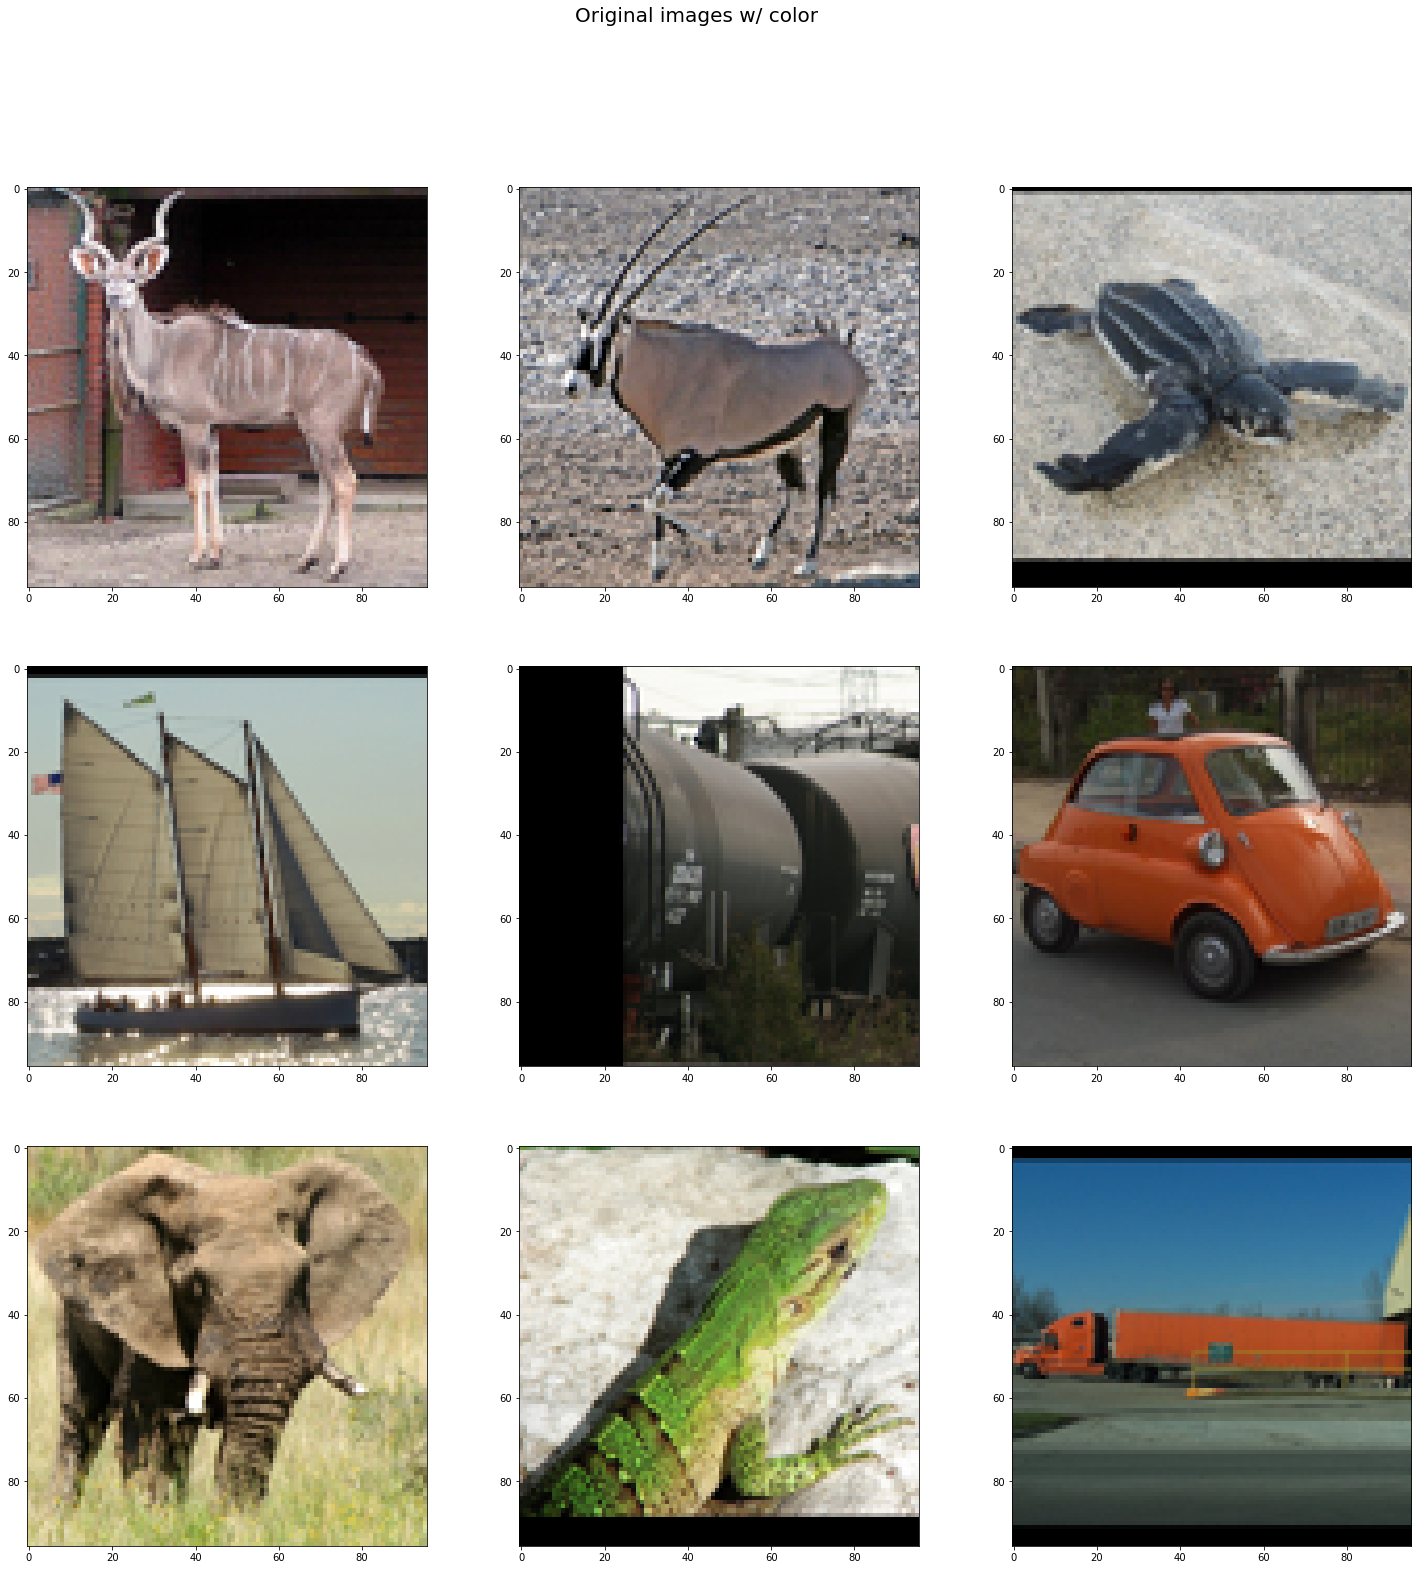

In [23]:
fig = plt.figure(figsize=(25, 25))  # width, height in inches
fig.suptitle("Original images w/ color", fontsize = 20)
for i in range(9):
    sub = fig.add_subplot(3, 3, i + 1)

    sub.imshow(test_data[i,:,:,:], interpolation='nearest')

In [12]:
test_one = test_data.reshape(8544, 8544, 3)
test_one.shape

(8544, 8544, 3)

In [13]:
import time
start = time.time()


unl_r = test_one[:,:,0]
unl_g = test_one[:,:,1]
unl_b = test_one[:,:,2]

end = time.time()
print(end - start)


0.0


1417.3786067962646


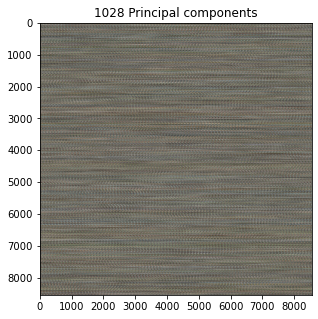

In [14]:
start = time.time()

rgb = pca_3d(unl_r, unl_g, unl_b, 1028); # Roughly 20 mins for n = 4, same for n = 2000

end = time.time()
print(end - start)

In [15]:
print(rgb.shape)
rgb = rgb.reshape(7921, 96, 96, 3)
print(rgb.shape)

(8544, 8544, 3)
(7921, 96, 96, 3)


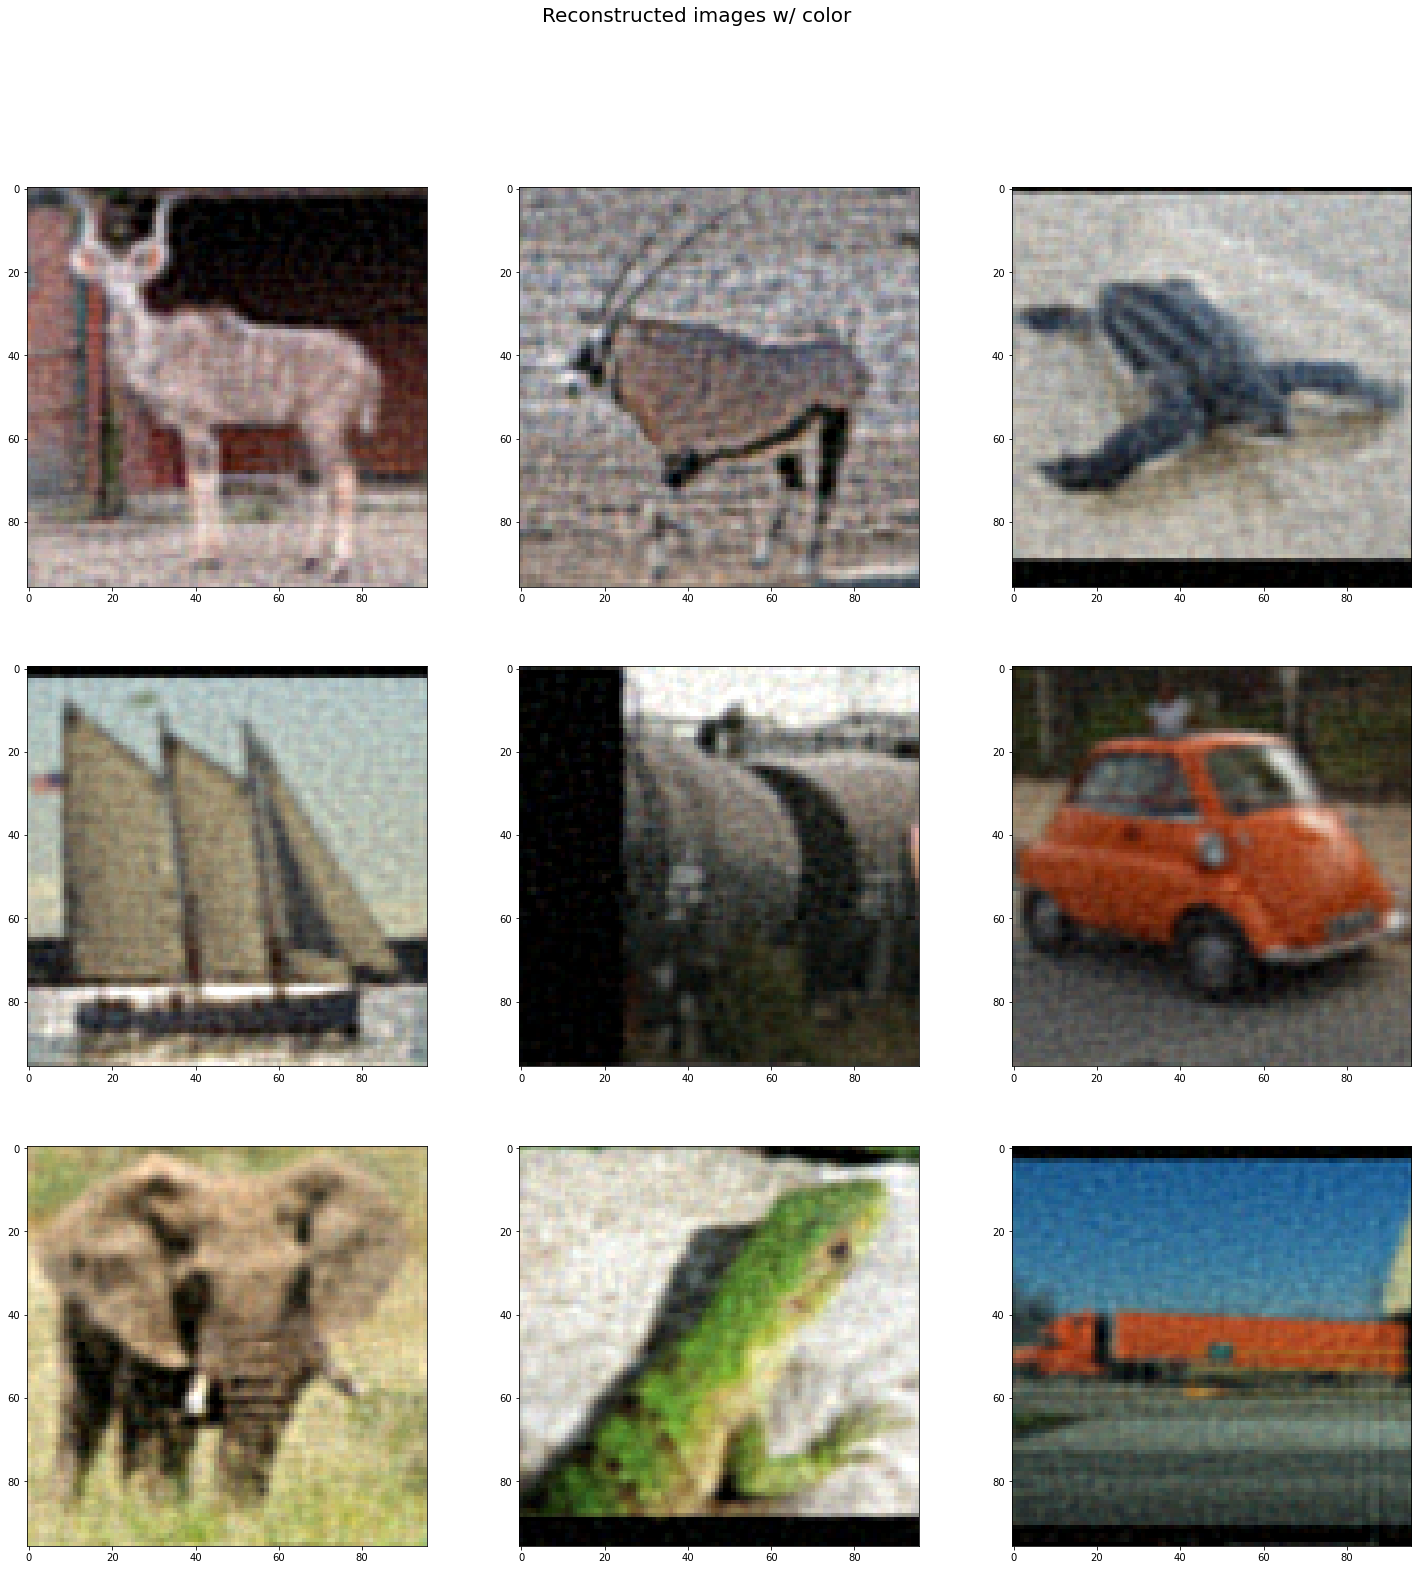

In [28]:
fig = plt.figure(figsize=(25, 25))  # width, height in inches
fig.suptitle("Reconstructed images w/ color", fontsize = 20)
for i in range(9):
    sub = fig.add_subplot(3, 3, i + 1)

    sub.imshow(rgb[i,:,:,:], interpolation='nearest')

As you can see above, the reconstruction works pretty well for when we use about 1000 principal components. While the initial plan was to use the entire colored test dataset for this portion, each run of the PCA algorithm takes about 20 minutes given our limited computing resources. Given that we've already proven that this method can work for colored images, we will switch to using grayscale images for faster computing. 

In [29]:
test_data = unlabelled[0:7921]
test_data = test_data / 255

test_data = test_data.reshape(8544, 8544, 3)
print(test_data.shape)
test_data.min(), test_data.max()

(8544, 8544, 3)


(0.0, 1.0)

Let's create our error function MSE

![title](https://i.imgur.com/vB3UAiH.jpg)

In [16]:
def mse(orig, recon):
    mse = (np.square(orig - recon)).mean()
    return mse


In [17]:
# Function to convert to grayscale

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [18]:
def pca_2d(image, num_components):
    if len(image.shape) > 2:
        image = np.mean(image,2)
    e_vecs,proj,e_vals = principal_components(image, num_components)
    Xr_r = np.dot(e_vecs,proj).T + np.mean(image,axis=0)
    Xr_r = np.clip(Xr_r, 0, 1)
    
    #plt.imshow(Xr_r, cmap = 'Greys_r')
    return Xr_r
    

In [33]:
test_data = rgb2gray(test_data)
test_data.shape

(8544, 8544)

In [34]:
#output = pca_2d(test_data, 2000) # Still takes roughly 9 mins

start = time.time()

values = [32, 64, 256, 512, 1028, 2046, 4098]
loss = []
for item in values:
    temp = pca_2d(test_data, item)
    loss.append([mse(test_data, temp), item] )
    
    
end = time.time()
print(end - start)  # Roughly 50 mins
    

2927.170122385025


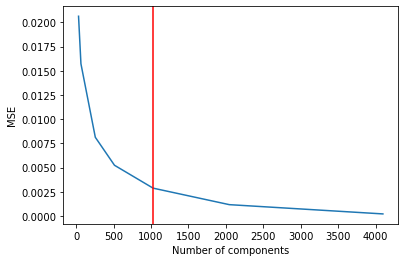

In [35]:
loss = np.array(loss)
plt.plot(loss[:,1], loss[:,0]);
plt.xlabel("Number of components")
plt.ylabel("MSE")
plt.axvline(x=1028, color='red');

Judging from the plot above, 1028 seems like a good number of components. A good balance between quality and size

In [36]:
output = pca_2d(test_data, 1028) # Still takes roughly 9 mins


In [37]:
output.shape

(8544, 8544)

In [38]:
final = output.reshape(7921, 96, 96)

In [39]:
final.shape

(7921, 96, 96)

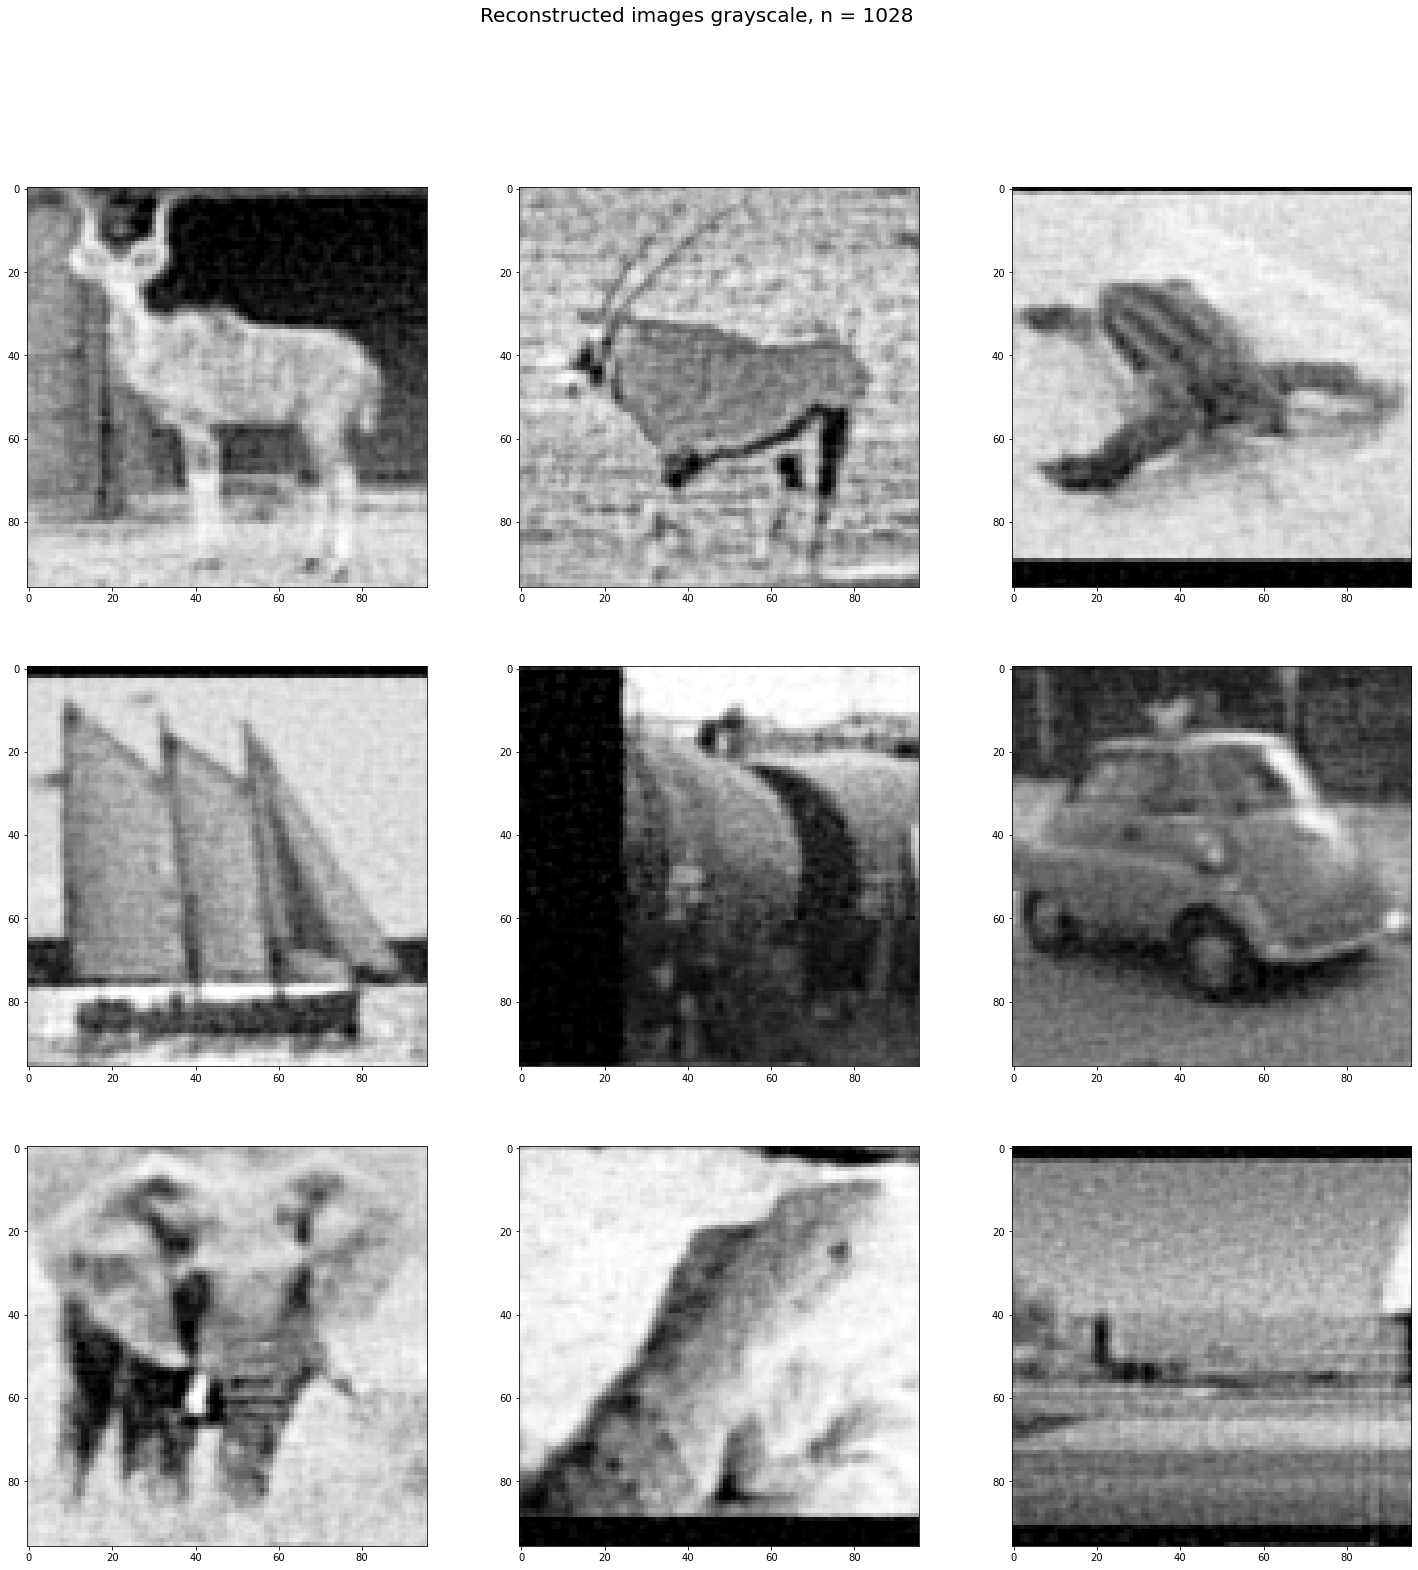

In [40]:
fig = plt.figure(figsize=(25, 25))  # width, height in inches
fig.suptitle("Reconstructed images grayscale, n = 1028", fontsize = 20)
for i in range(9):
    fig.add_subplot(3, 3, i + 1)

    plt.imshow(final[i,:,:], interpolation='nearest', cmap='Greys_r')

It's still a bit blurry, so let's try 2048 instead.

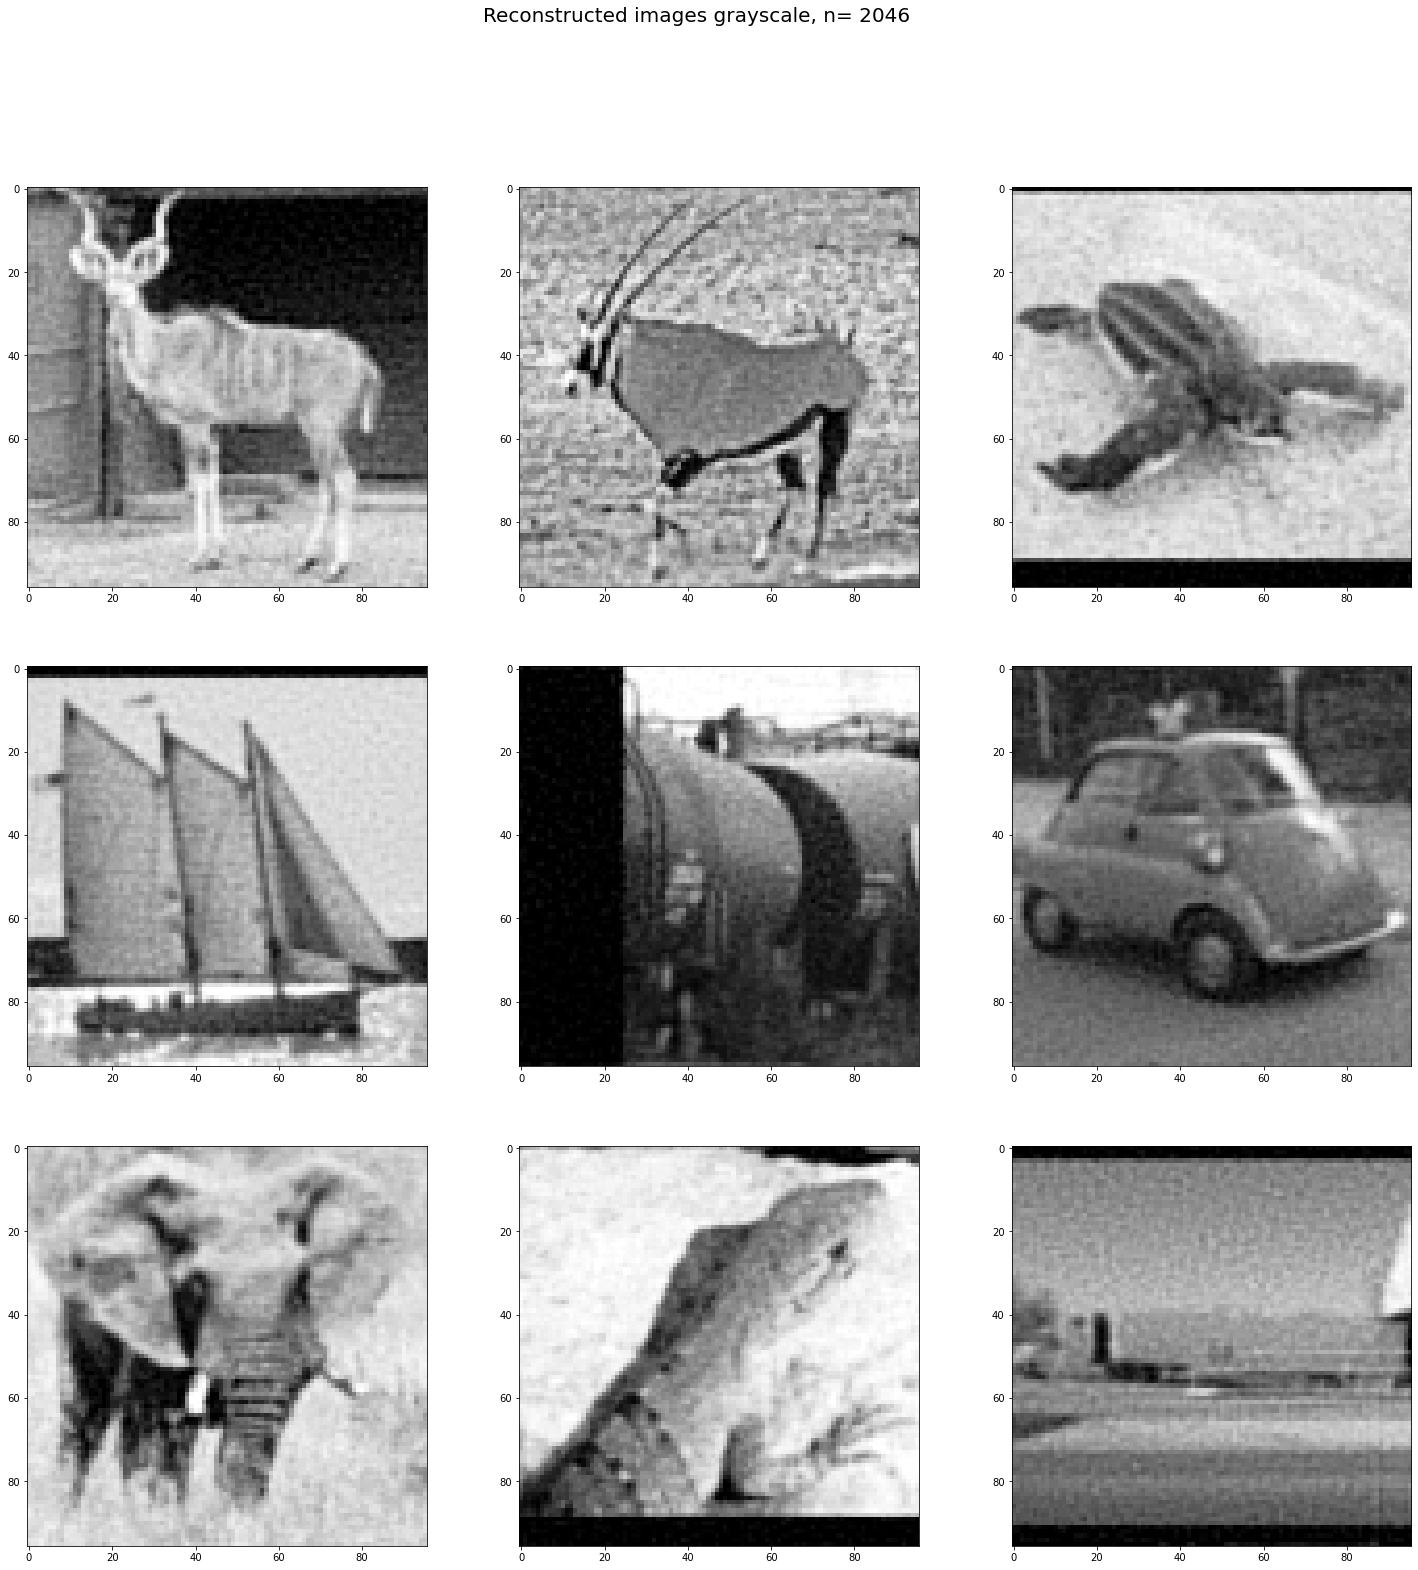

In [41]:
output = pca_2d(test_data, 2046) # Still takes roughly 9 mins
final = output.reshape(7921, 96, 96)

fig = plt.figure(figsize=(25, 25))  # width, height in inches
fig.suptitle("Reconstructed images grayscale, n= 2046", fontsize = 20)
for i in range(9):
    fig.add_subplot(3, 3, i + 1)

    plt.imshow(final[i,:,:], interpolation='nearest', cmap='Greys_r')

That looks better, but we'll treat n = 1028 as the optimal dimensions for faster computing.

Plotted below is the original grayscale images for comparison

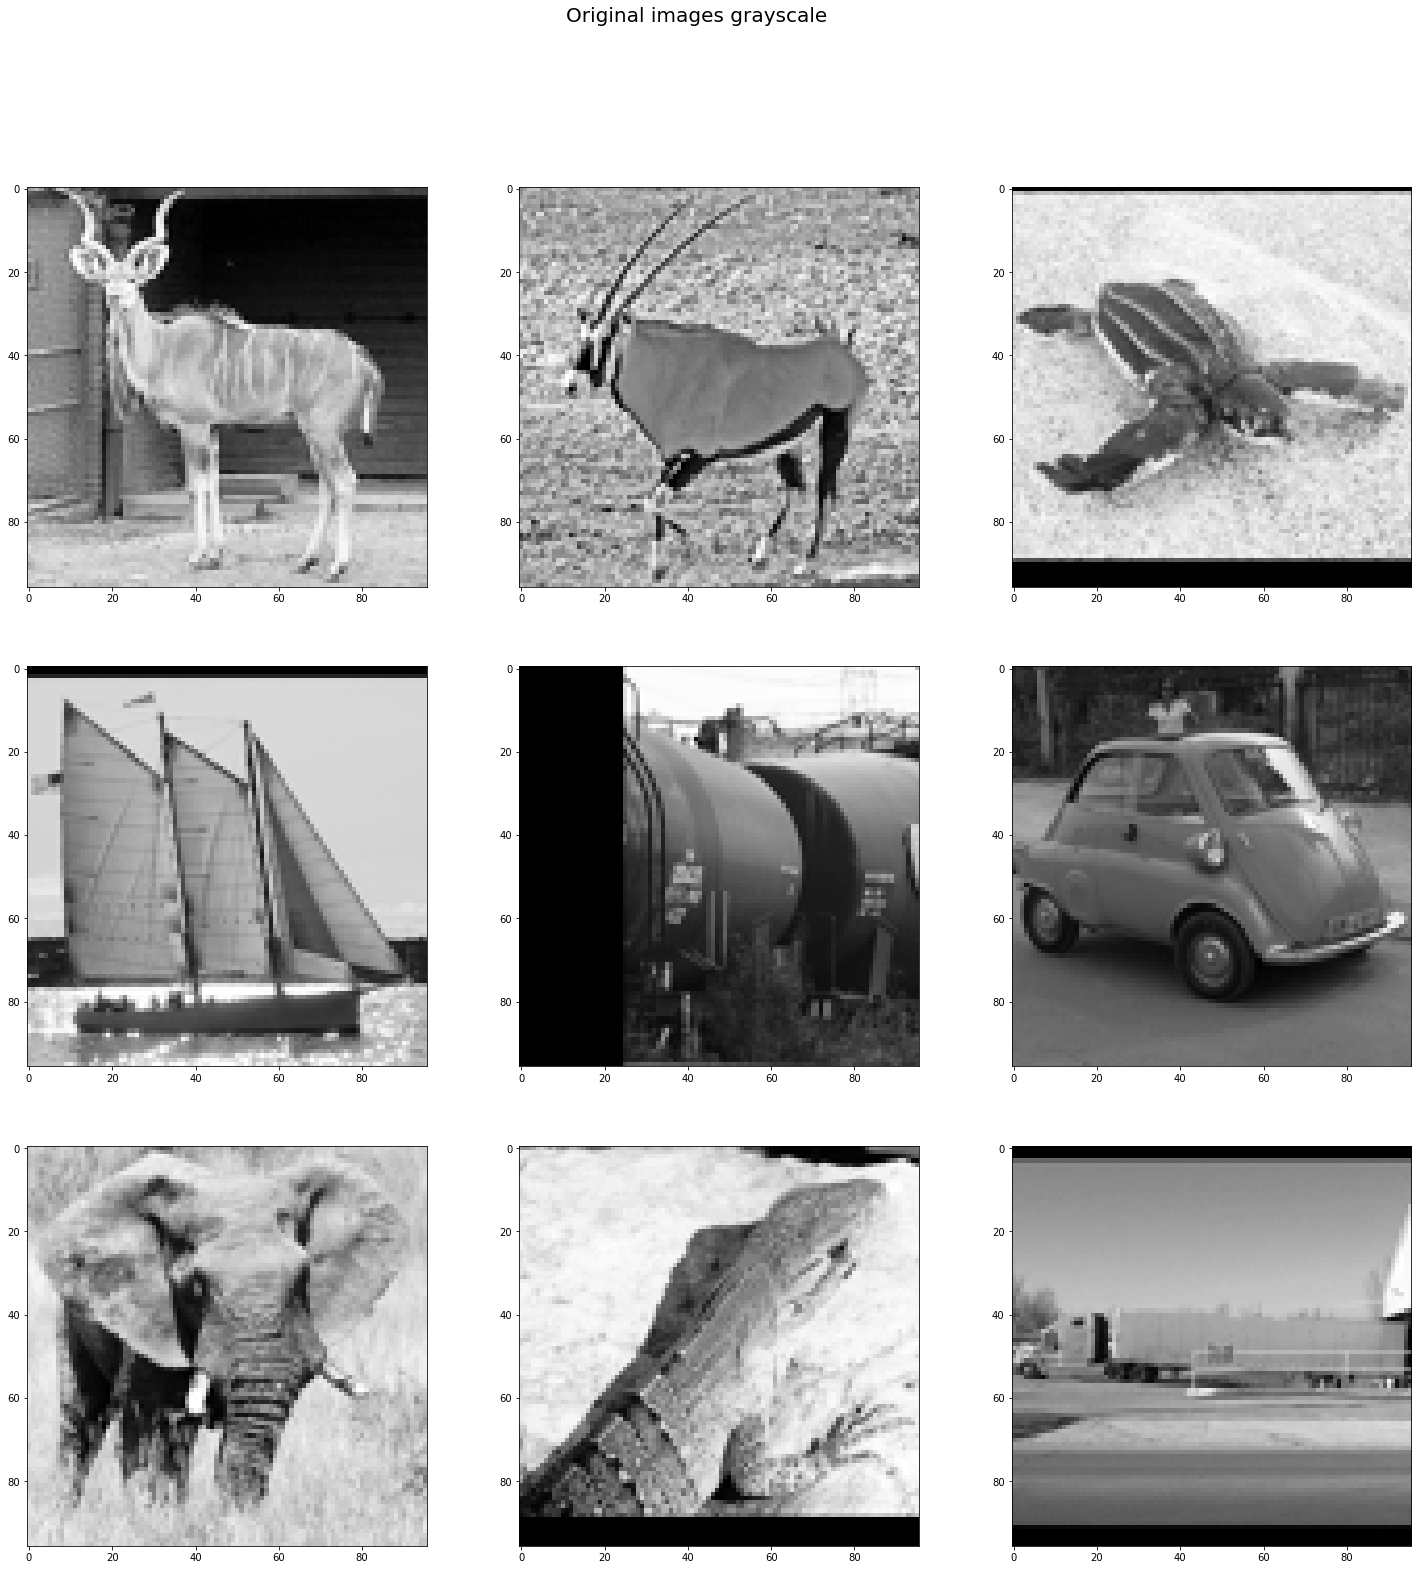

In [42]:
test_gray = test_data.reshape(7921, 96, 96)

fig = plt.figure(figsize=(25, 25))  # width, height in inches
fig.suptitle("Original images grayscale", fontsize = 20)
for i in range(9):
    sub = fig.add_subplot(3, 3, i + 1)

    sub.imshow(test_gray[i,:,:], interpolation='nearest', cmap='Greys_r')

## Part 2: GMM

Part 2: Using the “optimal” 𝒛−dim⁡in PCA


Can we fit a 10-component GMM on the unlabeled dataset 𝒛 code vectors from PCA?


Can we use the GMM and labeled train set to assign labels to the 10 clusters in GMM?


Report the accuracy on the test dataset.


Can we build an STL generative model using unlabeled dataset  PCA 𝒛 code vectors and GMM? 



In [43]:
# z-dim = 1028

## Gaussian Mixture Model


A Gaussian Mixture Model (GMM) tries to learn the true distributions of the given data. It tries to learn each cluster as a different Gaussian distribution. It assumes that the data is generated from a limited mixture of Gaussians.

### EM Algorithm

![title](https://media.geeksforgeeks.org/wp-content/uploads/20190512202126/em11.jpg)

The EM algorithm is an iterative approach that cycles between two modes. The first mode attempts to estimate the missing or latent variables, called the estimation-step or E-step. The second mode attempts to optimize the parameters of the model to best explain the data, called the maximization-step or M-step.


It is an appropriate approach to try and estimate the parameters of our Gaussian distributions.


In [19]:
import copy
from scipy.stats import multivariate_normal

In [20]:

import numpy as np

class GMM:
    '''
    Performs clustering of image data using a Gaussian Mixture Model.
    The model uses the EM algorithm to fit its parameters to the input image data.
    There is a multivariate Gaussian distribution for each cluster.
    The parameters fitted are the mean pixel value, the covariance matrix and the 
    weight of each Gaussian distribution.
    '''
    def __init__(self, n_clusters=3, max_iterations=100, tolerance=0.0015):
        '''
        Iniatializes the parameters of the EM algorithm.
        Parameters
        ----------
        n_clusters : int, optional
            The number of clusters the algorithm is going to fit. The default is 3.
        max_iterations : int, optional
            The number of iterations the EM algorithm is going to execute. The default is 100.
        tolerance : float, optional
            The percentage of change between the centroids of conconsecutive iterations
            tolerated. If the change is smaller the algorithm will be considered as
            converged. The default is 0.0015.
        Returns
        -------
        None.
        '''
        self.n_clusters = n_clusters
        self.max_iterations = max_iterations
        self.tolerance = tolerance

    def Initialize_parameters(self, data_points):
        '''
        Randomly initializes the parameters of each Gaussian distribution.\n
        It initializes n_cluster mean values of the same dimention as the datapoints.
        It initializes n_cluster covariance matrices. Each of these matrices is a 
        diagonal square matrix of the dimention of the datapoints.
        It initializes n_cluster weights for each distribution. The weights sum to one.
        
        Parameters
        ----------
        data_points : ndarray
            A 2D numpy array of all the datapoints and the dimention of the data.
        Returns
        -------
        None.
        '''
        from sklearn.datasets import make_spd_matrix
        self.means = np.random.permutation(data_points)[:self.n_clusters]
        self.covariances = np.zeros((self.n_clusters, data_points.shape[-1], data_points.shape[-1]))
        for c in range(self.n_clusters):
            self.covariances[c] = make_spd_matrix(data_points.shape[-1])
        self.weights = np.random.dirichlet(np.ones(self.n_clusters), size=1)[0]
        self.r = np.zeros((self.n_clusters, data_points.shape[0]))
        
    def N(self, x, mean, covariance):
        '''
        Calculates the probability value of the multivariate Gaussian distribution
        defined by the given mean and covariance matrix.
        Parameters
        ----------
        x : ndarray
            The data for which the propability is calculated.
        mean : ndarray
            The mean value of the distribution. The shape has to be the same as 
            that of the datapoints.
        covariance : ndarray
            A sqaure matrix of shape the same as that of the datapoints.
            The covariance matrix needs to be positively defined so that its 
            determinant is not zero.
        Returns
        -------
        ndarray
            The resulting probability values for x.
        '''
        d = len(x)
        return np.power(2 * np.pi, -d/2) * np.power(np.linalg.det(covariance), -1/2) * np.exp(-0.5 * (x - mean).T.dot(np.linalg.inv(covariance)).dot(x - mean))
        
    def E_Step(self, data_points):
        '''
        The Expectation step of the EM algorithm. This step calculates the responsibility
        of each datapoint for each cluster. What is the propability that each of
        the datapoints belongs to each cluster.
        Parameters
        ----------
        data_points : ndarray
            A 2D numpy array of all the datapoints and the dimention of the data.
        Returns
        -------
        None.
        '''        
        r = np.zeros((data_points.shape[0], self.n_clusters))
        for i in range(data_points.shape[0]):
            normalization = sum(self.weights[k] * self.N(data_points[i], self.means[k], self.covariances[k]) for k in range(self.n_clusters))
            for c in range(self.n_clusters):
                r[i][c] = self.weights[c] * self.N(data_points[i], self.means[c], self.covariances[c]) / normalization
        self.r = r
    
    def M_Step(self, r, data_points):
        '''
        This is the maximization step of the EM algorithm. This step updates the
        parameters of the Gaussian mixture model. It updates the means and the 
        covariances and the weights of each distribution based on the responibilities 
        that were calculated during the Expectation step.
        Parameters
        ----------
        r : ndarray
            The resopnsibilities calculated during the Expectation step.
        data_points : ndarray
            A 2D numpy array of all the datapoints and the dimention of the data..
        Returns
        -------
        None.
        '''
        m = sum(r)
        self.weights = m / self.n_clusters
        self.means = np.zeros(self.means.shape)
        self.covariances = np.zeros(self.covariances.shape)
        for i in range(data_points.shape[0]):
            for c in range(self.n_clusters):
                self.means[c] += r[i][c] * data_points[i] / m[c]
                temp = (data_points[i] - self.means[c]).reshape(1,-1)
                temp_t = (data_points[i] - self.means[c]).T.reshape(-1,1)
                self.covariances[c] += r[i][c] * temp_t.dot(temp) / m[c]
    
    def copy_means(self):
        '''
        Makes a copy of the means of the sistributions for comparison with the 
        changed means in the next iteration.
        Returns
        -------
        old_means : ndarray
            The means of the previous iteration.
        '''
        old_means = np.zeros(self.means.shape)
        for c in range(self.n_clusters):
            old_means[c] = self.means[c]
        return old_means
    
    def Convergence(self, old_means):
        '''
        Measures the change between the old and current means after each iteration.
        If the change is smaller than the tolerance then the EM algorithm has converged.
        Parameters
        ----------
        old_means : ndarray
            The means of the previous iteration.
        Returns
        -------
        convergence : Boolean
            A Boolean value of the convergence of the EM algorithm.
        '''
        convergence = False
        change = np.sum(np.abs(self.means - old_means) / (old_means * 100.0))
        if change < self.tolerance:
            convergence = True
        return convergence
    
    def fit(self, data):
        '''
        The distributions are fitted with the input image data using the EM algorithm.\n
        The parameters of the distributions are randomly initialized.\n
        The EM algorithm iterates a total of max_iterations, unless the convergence
        criterium is met.\n
        In each iteration the Expectation step and the Maximization step are executed.\n
        The means of each iteration are compared with the means of the previous 
        iteration, to check for convergence.
        Parameters
        ----------
        data : ndarray
            Input image data. This data is normalized before it is used in the
            EM algorithm.
        Returns
        -------
        None.
        '''
        data_points = data.reshape(-1, data.shape[-1]) / 255.0
        self.Initialize_parameters(data_points)
        
        for iteration in range(self.max_iterations):
            self.E_Step(data_points)
            old_means = self.copy_means()
            self.M_Step(self.r, data_points)
            if self.Convergence(old_means): break
            print('Iteration: ', iteration+1)
    
    def predict(self, data):
        '''
        Calculates which of the distributions best describes the input data.
        Parameters
        ----------
        data : ndarray
            Input image data.
        Returns
        -------
        ndarray
            A numpy array of the clustered image. Each pixel of the input image 
            data gets replaced by the mean of the distribution with the highest
            propability. This is the distribution that each pixel is most likely
            to be belong in.
        '''
        data_points = data.reshape(-1, data.shape[-1])
        clustered_data = np.zeros(data_points.shape)
        for i in range(data_points.shape[0]):
            ass = list(self.r[i])
            cluster = ass.index(max(ass))
            clustered_data[i] = self.means[cluster] * 255
        return clustered_data.reshape(data.shape).astype(int)



## Demo with small data first

In [46]:
demo = unlabelled[:16]
demo = demo.reshape(384, 384, 3)

In [47]:
# try clipping to not 0 to avoid zero division
demo = np.clip(demo, 0.0001, 255)

In [48]:
gmm_demo = GMM(n_clusters=10, max_iterations= 10) # 2:06
gmm_demo.fit(demo) 

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10


In [49]:
# The means of the clusters get stored in gmm_demo.means
gmm_demo.means

array([[0.51685589, 0.49478866, 0.44272334],
       [0.52994984, 0.50001915, 0.42432581],
       [0.52327023, 0.48783764, 0.4102626 ],
       [0.53114124, 0.49995075, 0.42193812],
       [0.28651469, 0.35137008, 0.15464901],
       [0.38989553, 0.38627627, 0.37600479],
       [0.41660719, 0.3707193 , 0.39150786],
       [0.47398688, 0.48051749, 0.29008342],
       [0.43932878, 0.41977998, 0.38222583],
       [0.50398239, 0.42647936, 0.29237873]])

Using our predict function, we can generate new clustered images based on the different clusters that our GMM found

In [50]:
res_demo = gmm_demo.predict(demo) 


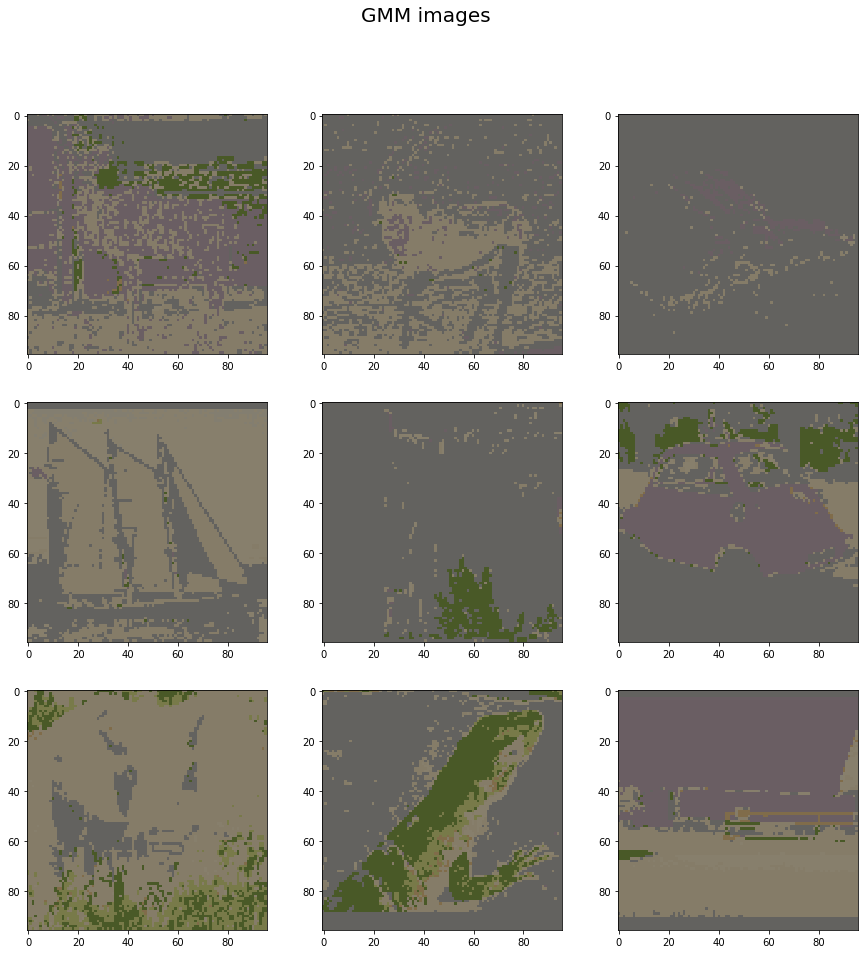

In [51]:
res_recon = res_demo.reshape(16, 96, 96, 3)
fig = plt.figure(figsize=(15, 15))  # width, height in inches
fig.suptitle("GMM images ", fontsize = 20)
for i in range(9):
    fig.add_subplot(3, 3, i + 1)

    plt.imshow(res_recon[i,:,:, :], interpolation='nearest')

# Implementation

In [21]:
print(rgb.shape)
rgb.min(), rgb.max()

(7921, 96, 96, 3)


(0.0, 1.0)

In [22]:
rgb1 = rgb * 255

In [23]:
rgb1.min(), rgb1.max()

(0.0, 255.0)

In [24]:
rgb1 = np.clip(rgb1, 0.0001, 255)

Due to computing limitations, we decided to use a smaller subset of our data.

In [25]:
test_1 = rgb1[0:225]
#test_1 = test_1 /255
test_1.shape

(225, 96, 96, 3)

In [26]:
test_2 = test_1.reshape(1440, 1440, 3)

In [27]:
data = test_2
data.shape

(1440, 1440, 3)

Since the code takes very long to run, we decided instead to increase the number of iterations on a smaller dataset

In [28]:
# gmm = GMM(n_clusters=10, max_iterations= 1) # 2:17 AM, 9 images = 18 mins for 6 iterations
# gmm.fit(data) # set to 1 iteration for time purposes

# Let's try 1024 w only 1 iteration, 10 clusters # 8:30 AM - 1:20 PM (almost 5 hours)

gmm = GMM(n_clusters=10, max_iterations= 5) # 2:17 AM, 9 images = 18 mins for 6 iterations
gmm.fit(data)  #7:22 am - 8:31 AM, 1 iteration

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


In [29]:
clusters = (gmm.means * 255).tolist()

In [31]:
def gmm_mean(set1, set2):
    stay = []
    for i in range(len(set1)):
        
        temp = abs(set1[i] - set2[i])
        #print(temp)
        stay.append(temp)
   # pri
    return (sum(stay))
    
        
        

In [32]:
res = gmm.predict(data) #1:31


In [33]:
res.shape

(1440, 1440, 3)

In [34]:
owo = res.reshape(225, 96, 96, 3)

In [35]:
owo.shape

(225, 96, 96, 3)

In [36]:
owo.max()

129

In [37]:
answer = []
for i in range(owo.shape[0]):
    answer.append([ owo[i][:,:,0].mean(), owo[i][:,:,1].mean(), owo[i][:,:,2].mean()  ])

In [38]:
answer = np.array(answer)

In [39]:
clusters = np.array(clusters)

In [40]:
scores = []
preds = []
for x in answer:
    for item in clusters:
        scores.append( gmm_mean(item, x) )
        #print(scores)
    preds.append(scores.index(min(scores)))
    scores = []

Now we test the accuracy of our 10 clusters with the test dataset.

In [46]:
check = 0;
for i in range(len(preds)):
    if y_test[i] == preds[i]:
        check += 1
score = check/float(len(preds))
print(f"{100 * score} % Accuracy")

9.777777777777779 % Accuracy


The results aren't great. Although that is to be expected for a few reasons; we used a smaller subset of data due to limited computing resources; our unlabelled dataset might have different actual labels from our test dataset, and the mapping of their true labels might be incorrect. Also, the process seems to recognize the black space between pictures as clusters, which is why the images tend to be very dark.

In [43]:
res_recon = res.reshape(225, 96, 96, 3)

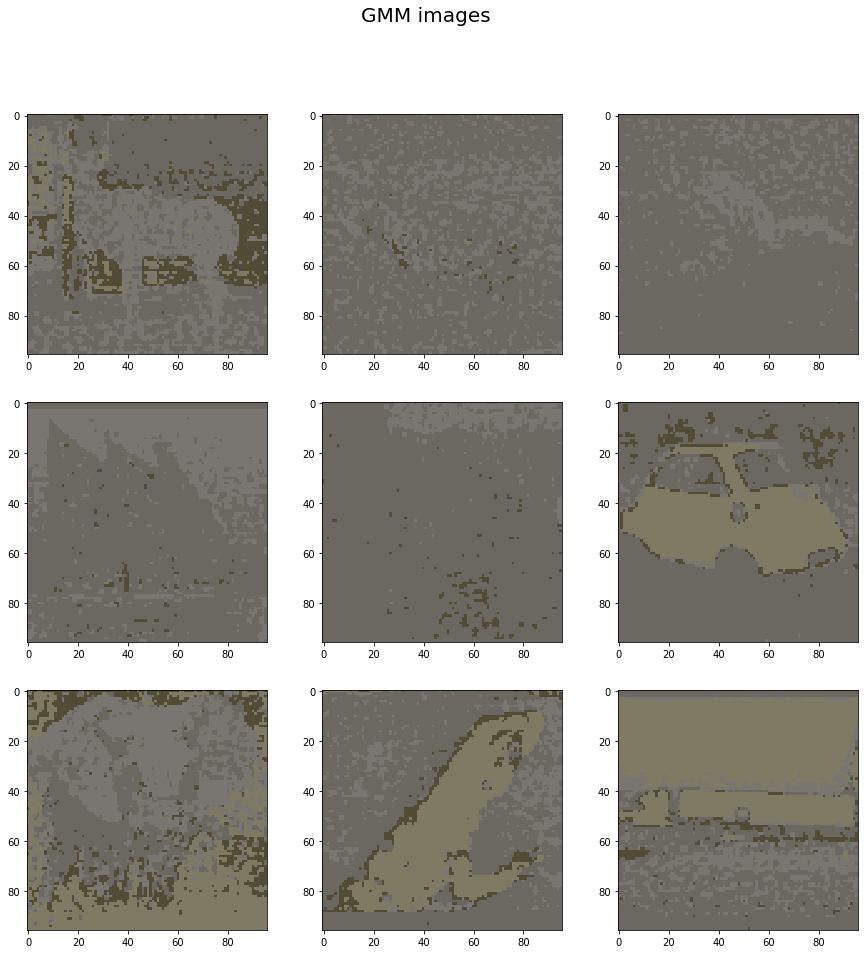

In [44]:
fig = plt.figure(figsize=(15, 15))  # width, height in inches
fig.suptitle("GMM images ", fontsize = 20)
for i in range(9):
    fig.add_subplot(3, 3, i + 1)

    plt.imshow(res_recon[i,:,:, :], interpolation='nearest')

## References:


PCA
- https://github.com/roatienza/ml/blob/master/pca/notebook/pca.ipynb
- https://github.com/NourozR/Reconstruction-and-Compression-of-Color-Images/blob/master/image_reconstruction_using_PCA.py
- https://github.com/matanby/keras-examples/blob/master/stl10.ipynb
- https://towardsdatascience.com/principal-component-analysis-in-depth-understanding-through-image-visualization-892922f77d9f
- https://www.askpython.com/python/examples/principal-component-analysis-for-image-data
- https://github.com/ad1m/PCA_Facial_Reconstruction/blob/master/PCA_Facial_Reconstruction.ipynb
- https://github.com/krishnr/PCA/blob/master/PCA.ipynb

GMM
- http://ethen8181.github.io/machine-learning/clustering/GMM/GMM.html
- https://github.com/VictorMegir/Gaussian-Mixture-Model-for-image-clustering/blob/master/GMM_demo.ipynb
- https://morioh.com/p/c80c2b14cd3b
- https://machinelearningmastery.com/expectation-maximization-em-algorithm/#:~:text=The%20EM%20algorithm%20is%20an,%2Dstep%20or%20M%2Dstep.
- https://towardsdatascience.com/gaussian-mixture-modelling-gmm-833c88587c7f